## Setup

In [ ]:


import matplotlib.pyplot as plt
import contextily as ctx


from io import BytesIO, StringIO
from owslib.wfs import WebFeatureService
from shapely.geometry import box
import geopandas as gpd
import requests
import pandas as pd
import pandas as pd
import geopandas as gpd
import requests
from io import StringIO

import boto3
import duckdb


import matplotlib.pyplot as plt

import numpy as np
import s2sphere
from botocore.config import Config
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import rasterstats
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from rasterio.features import rasterize
import numpy as np


import rioxarray
from shapely.geometry import box
from shapely.geometry import box


USE_CRS = "EPSG:5349"


# Generic mapping functions
def setup_base_map(figsize=(12, 10), bounds=None, padding_x=500, padding_y=500):
    """Create figure and set up basic map boundaries with padding."""
    if bounds is None:
        bounds = renabap_pba_intersect.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs("EPSG:3857").total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""
    # The axes are already in Web Mercator from setup_base_map
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    # Add north arrow, https://stackoverflow.com/a/58110049/604456
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=14,
                xycoords=ax.transAxes)


def add_la_plata_outline(ax):
    """Add the outline of Partido de La Plata to a map."""
    la_plata_3857 = la_plata.to_crs("EPSG:3857")
    la_plata_3857.plot(
        ax=ax,
        facecolor='none',
        edgecolor='black',
        linewidth=0.5,
        linestyle='--',
        legend=False,
        zorder=5
    )

def create_consistent_map(title, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds)

    # Add basemap
    add_basemap(ax)

    # Add north arrow
    add_north_arrow(ax)

    # Add La Plata partido outline
    add_la_plata_outline(ax)

    # Set title
    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    # Remove axes
    ax.set_axis_off()

    return fig, ax



def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf




In [2]:
response = requests.get(
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [3]:
peligro_path = "/home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson"
peligro = gpd.read_file(peligro_path)
peligro = peligro.to_crs(USE_CRS)

DataSourceError: /home/nissim/Documents/dev/ciut-inundaciones/data/la_plata_pelig_2023_datos_originales.geojson: No such file or directory

In [ ]:
# Get the bounds of the peligro layer
peligro_bounds = peligro.total_bounds

# Create a bounding box geometry from the peligro bounds
peligro_bbox = box(*peligro_bounds)

# Filter renabap_pba to only include geometries that intersect with the peligro bounds
renabap_pba_intersect = renabap_pba[
    renabap_pba.geometry.intersects(peligro_bbox)
].copy()

## Areal Interpolation, Unweighted

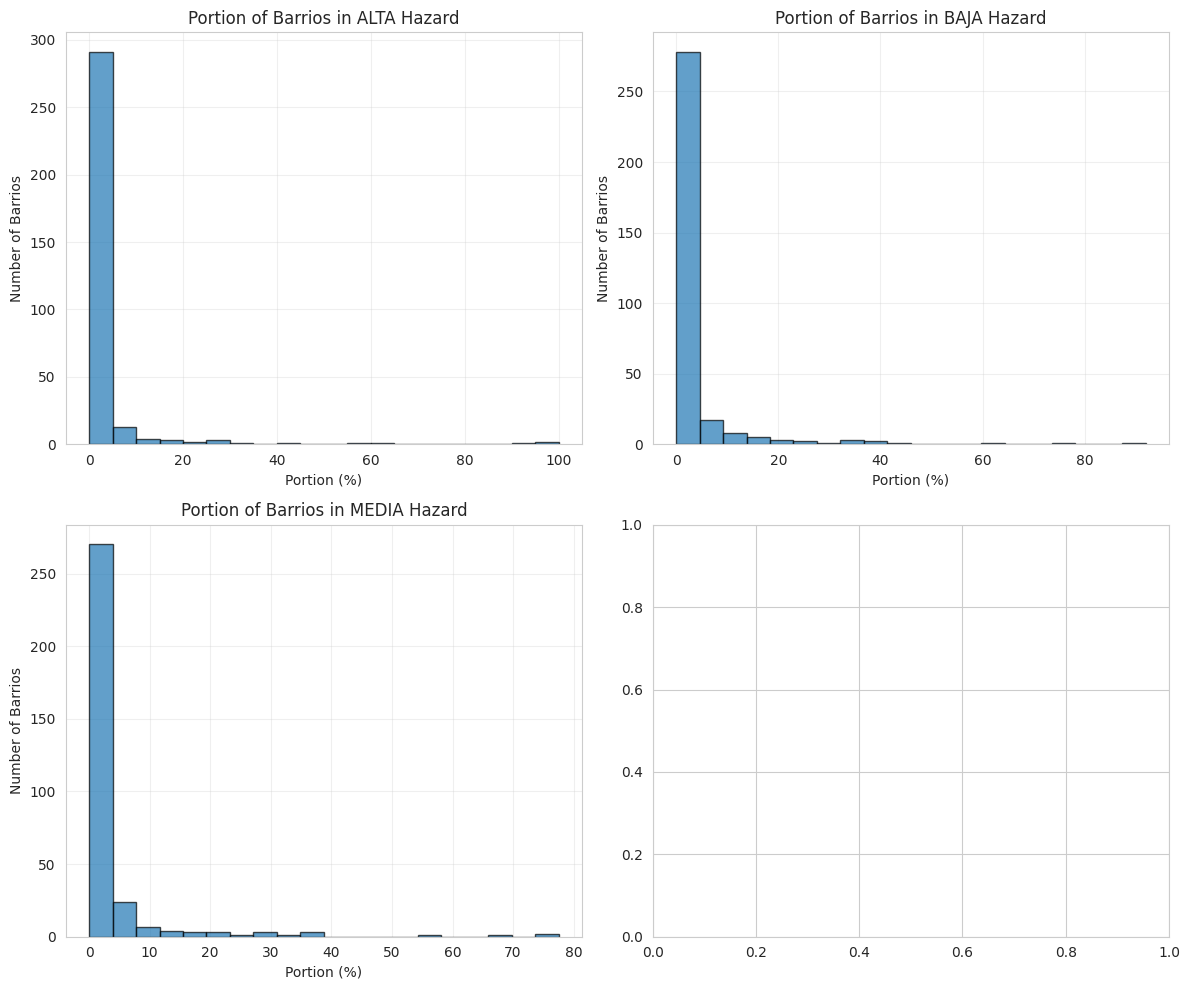

ALTA: Mean=2.8%, Max=100.0%, Barrios with >0%: 91
BAJA: Mean=3.1%, Max=91.9%, Barrios with >0%: 167
MEDIA: Mean=3.1%, Max=77.5%, Barrios with >0%: 145


In [35]:
# Create a single figure with subplots for each hazard level
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot histogram for each hazard level
for i, level in enumerate(hazard_levels):
    data = renabap_pba_intersect[f"porcion_{level}"] * 100  # Convert to percentage
    axes[i].hist(data, bins=20, alpha=0.7, edgecolor="black")
    axes[i].set_title(f"Portion of Barrios in {level.upper()} Hazard")
    axes[i].set_xlabel("Portion (%)")
    axes[i].set_ylabel("Number of Barrios")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
for level in hazard_levels:
    data = renabap_pba_intersect[f"porcion_{level}"] * 100
    print(
        f"{level.upper()}: Mean={data.mean():.1f}%, Max={data.max():.1f}%, Barrios with >0%: {(data > 0).sum()}"
    )

In [36]:
# Calculate families exposed to each hazard level
for level in hazard_levels:
    renabap_pba_intersect[f"familias_expuestas_{level}"] = (
        renabap_pba_intersect[f"porcion_{level}"]
        * renabap_pba_intersect["familias_aproximadas"]
    )

# Summary
total_familias = renabap_pba_intersect["familias_aproximadas"].sum()
print(f"Total families in dataset: {total_familias:.0f}")

for level in hazard_levels:
    total_exposed = renabap_pba_intersect[f"familias_expuestas_{level}"].sum()
    print(f"Total families exposed to {level} hazard: {total_exposed:.0f}")

Total families in dataset: 88856
Total families exposed to alta hazard: 2694
Total families exposed to baja hazard: 3786
Total families exposed to media hazard: 4345


In [38]:
# Create tidy dataframe with the three required columns
renabap_tidy = renabap_pba_intersect[["id_renabap"]].copy()

# Calculate total familias_expuestas
renabap_tidy["fam_expuestas_areal"] = (
    renabap_pba_intersect["familias_expuestas_alta"]
    + renabap_pba_intersect["familias_expuestas_baja"]
    + renabap_pba_intersect["familias_expuestas_media"]
)

# Determine highest hazard level (peligrosidad)
def get_highest_hazard(row):
    exposures = [
        row["familias_expuestas_alta"],
        row["familias_expuestas_baja"],
        row["familias_expuestas_media"],
    ]
    hazard_levels = ["alta", "baja", "media"]
    return hazard_levels[exposures.index(max(exposures))]

renabap_tidy["peligrosidad"] = renabap_pba_intersect.apply(get_highest_hazard, axis=1)

# Round fam_expuestas_areal
renabap_tidy["fam_expuestas_areal"] = renabap_tidy["fam_expuestas_areal"].round(2)

print(renabap_tidy.head())

   id_renabap  fam_expuestas_areal peligrosidad
1           2                 0.06         baja
2           3                14.15         baja
3           4                 3.46        media
4           5                 2.79         alta
5           6                 0.28         alta


## Areal Interpolation, GHSL Weighting

In [26]:
import rioxarray
from shapely.geometry import box

# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    "/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif",
    chunks={"x": 1024, "y": 1024},  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

# Clip to renabap_pba_intersect bounding box using streaming
bounding_box = box(
    *renabap_pba_intersect.total_bounds
)  # Create a box from the bounding box coordinates

ghsl_clipped = ghsl.rio.clip(
    [bounding_box],  # Use the bounding box as a geometry (wrapped in a list)
    from_disk=True,  # Process from disk to avoid loading entire dataset into memory
)


# If you need to compute the result (only when you actually need the data)
# ghsl_final = ghsl_clipped.compute()

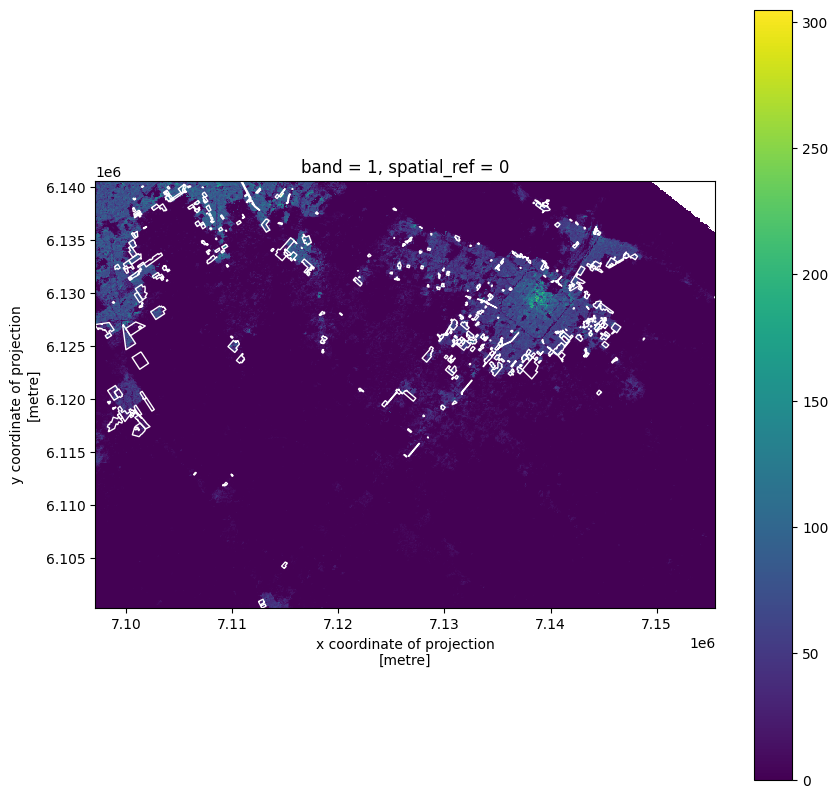

In [6]:
import matplotlib.pyplot as plt

# Create a plot with the desired size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GHSL clipped data on the ax, excluding values below 0
ghsl_clipped_positive = ghsl_clipped.where(ghsl_clipped >= 0)
ghsl_clipped_positive.plot(ax=ax, cmap="viridis")

# Plot the RENABAP polygons on top of the raster
renabap_pba_intersect.plot(ax=ax, edgecolor="white", facecolor="none")

# Show the plot
plt.show()

In [27]:
import rasterstats

# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics
print("Calculating GHSL population totals per barrio popular...")

# Convert to the format expected by rasterstats
geometries = [geom for geom in renabap_pba_intersect.geometry]

# Use rasterstats for vectorized zonal statistics
stats = rasterstats.zonal_stats(
    geometries,
    ghsl_clipped.values[0],  # rasterstats expects 2D array
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=ghsl_clipped.rio.nodata,
)

# Extract the sum values
ghsl_totals = [stat["sum"] if stat["sum"] is not None else 0 for stat in stats]

# Add the GHSL population estimates as a new column
renabap_pba_intersect["ghsl_pop_est"] = ghsl_totals

# Verify the results
print(f"Added GHSL population estimates to {len(ghsl_totals)} barrios")
print(f"Total estimated population: {sum(ghsl_totals):,.0f}")
print(f"Range: {min(ghsl_totals):.0f} - {max(ghsl_totals):.0f}")

# Show a few examples
print("\nFirst 5 barrios with GHSL estimates:")
print(renabap_pba_intersect[["geometry", "ghsl_pop_est"]].head())

Calculating GHSL population totals per barrio popular...
Added GHSL population estimates to 323 barrios
Total estimated population: 257,167
Range: 0 - 9332

First 5 barrios with GHSL estimates:
                                            geometry  ghsl_pop_est
1  MULTIPOLYGON (((7133413.584 6125858.719, 71336...    729.961555
2  MULTIPOLYGON (((7127613.216 6115863.573, 71276...    240.369900
3  MULTIPOLYGON (((7136174.621 6130304.579, 71361...    265.001049
4  MULTIPOLYGON (((7128546.05 6130775.49, 7128519...     10.639407
5  MULTIPOLYGON (((7129976.453 6132330.669, 71299...      0.000000


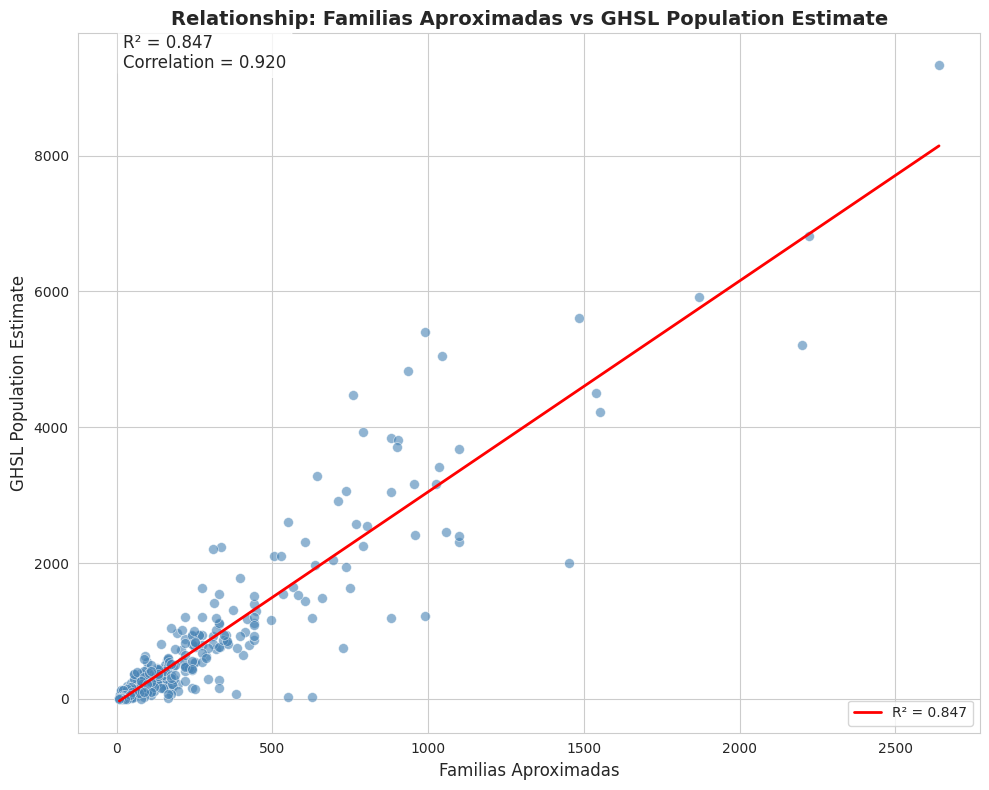

Number of observations: 323
R-squared: 0.847
Correlation coefficient: 0.920
P-value: 7.084e-133
Slope: 3.107
Intercept: -58.472


In [28]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Filter out any NaN values for the analysis
valid_data = renabap_pba_intersect.dropna(
    subset=["familias_aproximadas", "ghsl_pop_est"]
)

# Calculate correlation and R-squared
correlation, p_value = stats.pearsonr(
    valid_data["familias_aproximadas"], valid_data["ghsl_pop_est"]
)
r_squared = correlation**2

# Calculate line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(
    valid_data["familias_aproximadas"], valid_data["ghsl_pop_est"]
)

# Create the plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Scatter plot
plt.scatter(
    valid_data["familias_aproximadas"],
    valid_data["ghsl_pop_est"],
    alpha=0.6,
    s=50,
    color="steelblue",
    edgecolors="white",
    linewidth=0.5,
)

# Line of best fit
x_range = np.linspace(
    valid_data["familias_aproximadas"].min(),
    valid_data["familias_aproximadas"].max(),
    100,
)
y_fit = slope * x_range + intercept
plt.plot(x_range, y_fit, color="red", linewidth=2, label=f"R² = {r_squared:.3f}")

# Add labels and title
plt.xlabel("Familias Aproximadas", fontsize=12)
plt.ylabel("GHSL Population Estimate", fontsize=12)
plt.title(
    "Relationship: Familias Aproximadas vs GHSL Population Estimate",
    fontsize=14,
    fontweight="bold",
)

# Add R-squared text
plt.text(
    0.05,
    0.95,
    f"R² = {r_squared:.3f}\nCorrelation = {correlation:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of observations: {len(valid_data)}")
print(f"R-squared: {r_squared:.3f}")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Slope: {slope:.3f}")
print(f"Intercept: {intercept:.3f}")

In [29]:
from rasterio.features import rasterize
import numpy as np

# Get the reference raster properties from GHSL data
reference_raster = ghsl_clipped
reference_transform = reference_raster.rio.transform()
reference_crs = reference_raster.rio.crs
reference_shape = reference_raster.shape[1:]  # Get 2D shape (height, width)

print(f"Reference raster shape: {reference_shape}")
print(f"Reference CRS: {reference_crs}")

# Prepare geometries and values for rasterization
geometries_ghsl = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["ghsl_pop_est"]
    )
]
geometries_familias = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["familias_aproximadas"]
    )
]

Reference raster shape: (490, 711)
Reference CRS: EPSG:5349


In [30]:
# Create GHSL population raster
ghsl_pop_raster = rasterize(
    geometries_ghsl,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)

# Create familias aproximadas raster
familias_raster = rasterize(
    geometries_familias,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)

# Verify the rasters
print(
    f"GHSL population range: {np.nanmin(ghsl_pop_raster):.2f} - {np.nanmax(ghsl_pop_raster):.2f}"
)
print(
    f"Familias range: {np.nanmin(familias_raster):.2f} - {np.nanmax(familias_raster):.2f}"
)

GHSL population range: 0.00 - 9332.04
Familias range: 0.00 - 2640.00


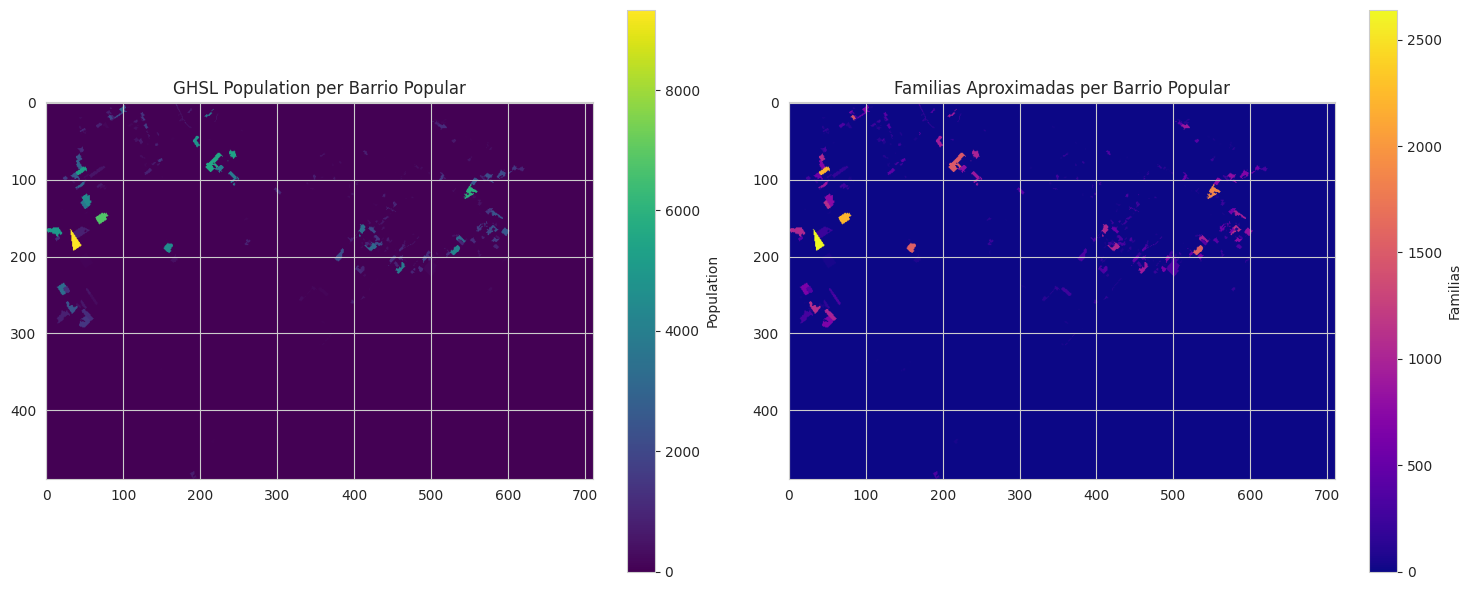

In [31]:
# Optional: Create a quick visualization to verify
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot GHSL population raster
im1 = ax1.imshow(ghsl_pop_raster, cmap="viridis")
ax1.set_title("GHSL Population per Barrio Popular")
plt.colorbar(im1, ax=ax1, label="Population")

# Plot familias raster
im2 = ax2.imshow(familias_raster, cmap="plasma")
ax2.set_title("Familias Aproximadas per Barrio Popular")
plt.colorbar(im2, ax=ax2, label="Familias")

plt.tight_layout()
plt.show()

Original GHSL range: -200.00 - 304.95
Fractional population range: -200.0000 - 1.0000
Downscaled familias range: -200.00 - 383.00

Total original familias: 88,856
Total downscaled familias: 88,680
Difference: 176.00


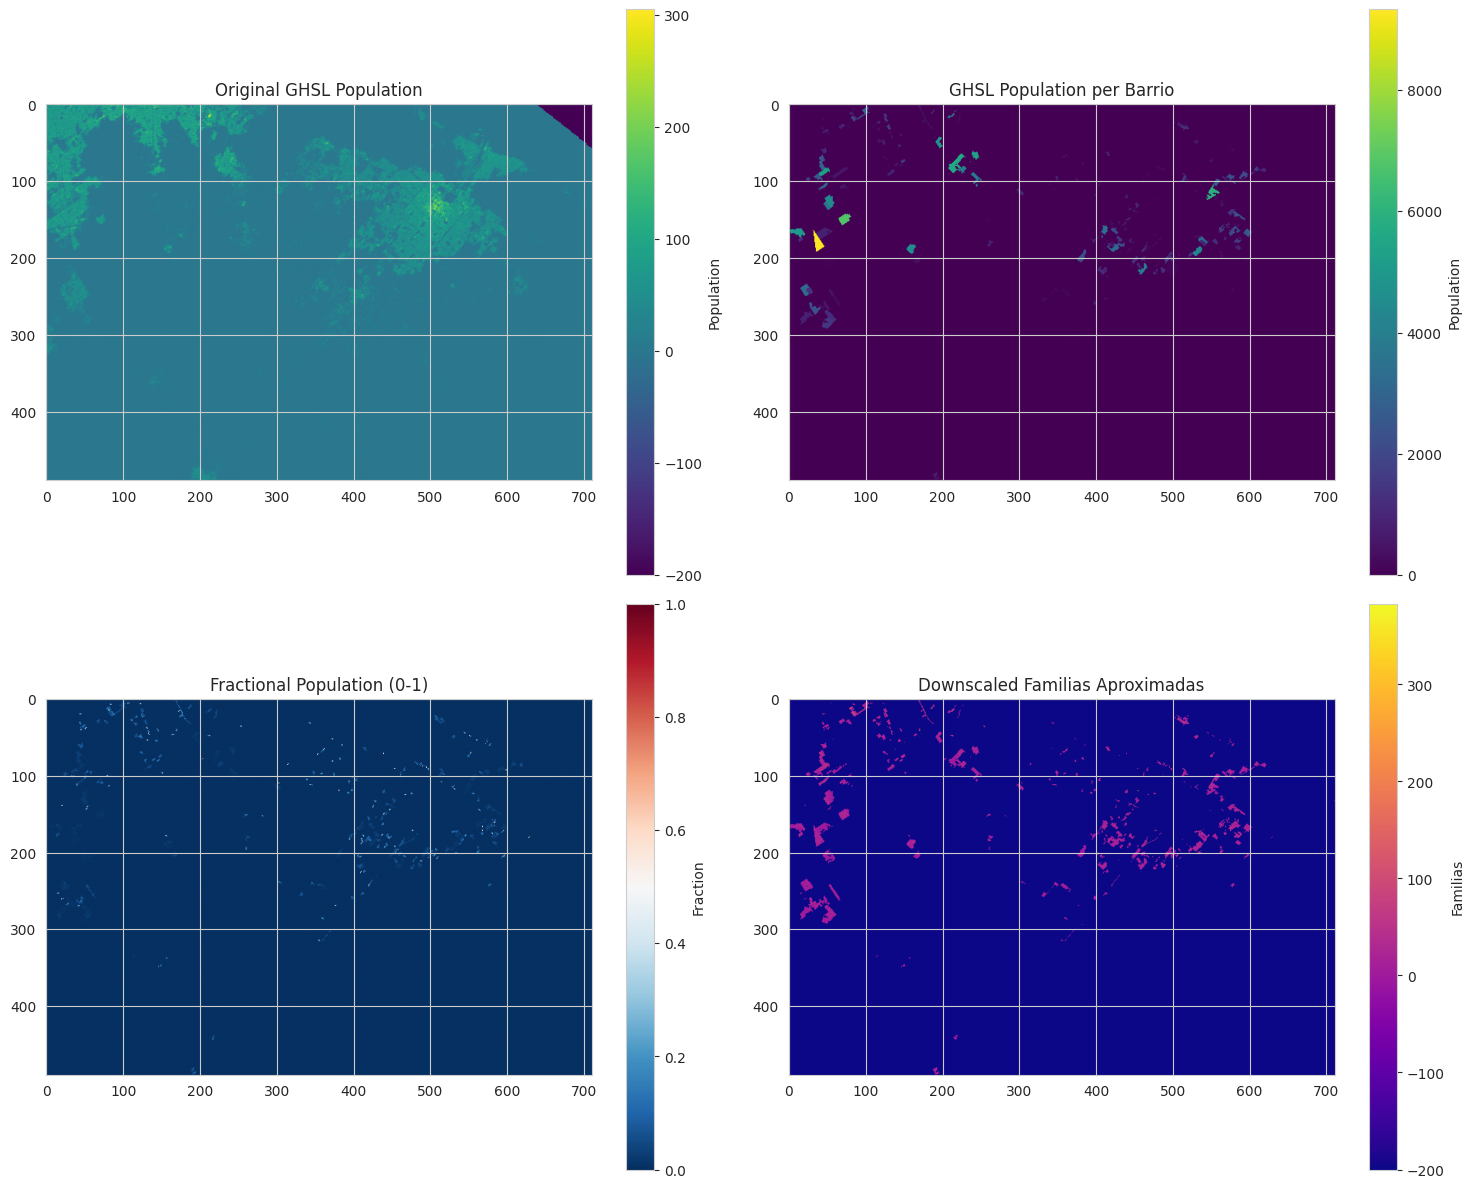

In [32]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Handle division by zero and nodata values properly
mask = (ghsl_clipped.values[0] > 0) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional > 0) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results
print(
    f"Original GHSL range: {np.nanmin(ghsl_clipped.values[0]):.2f} - {np.nanmax(ghsl_clipped.values[0]):.2f}"
)
print(
    f"Fractional population range: {np.nanmin(ghsl_fractional):.4f} - {np.nanmax(ghsl_fractional):.4f}"
)
print(
    f"Downscaled familias range: {np.nanmin(familias_downscaled):.2f} - {np.nanmax(familias_downscaled):.2f}"
)

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect["familias_aproximadas"].sum()
valid_downscaled = familias_downscaled[familias_downscaled != -200]
total_downscaled_familias = np.sum(valid_downscaled)
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

# Optional: Create visualization to verify the downscaling
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Original GHSL
im1 = ax1.imshow(ghsl_clipped.values[0], cmap="viridis")
ax1.set_title("Original GHSL Population")
plt.colorbar(im1, ax=ax1, label="Population")

# Barrio-level GHSL
im2 = ax2.imshow(ghsl_pop_raster, cmap="viridis")
ax2.set_title("GHSL Population per Barrio")
plt.colorbar(im2, ax=ax2, label="Population")

# Fractional population
im3 = ax3.imshow(ghsl_fractional, cmap="RdBu_r", vmin=0, vmax=1)
ax3.set_title("Fractional Population (0-1)")
plt.colorbar(im3, ax=ax3, label="Fraction")

# Downscaled familias
im4 = ax4.imshow(familias_downscaled, cmap="plasma")
ax4.set_title("Downscaled Familias Aproximadas")
plt.colorbar(im4, ax=ax4, label="Familias")

plt.tight_layout()
plt.show()

In [33]:
# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Use masking to avoid division on invalid cells
mask = (ghsl_clipped.values[0] != -200) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional != -200) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results - exclude -200 from range calculations
ghsl_valid = ghsl_clipped.values[0] != -200
fractional_valid = ghsl_fractional != -200
downscaled_valid = familias_downscaled != -200

print(
    f"Original GHSL range: {np.min(ghsl_clipped.values[0][ghsl_valid]):.2f} - {np.max(ghsl_clipped.values[0][ghsl_valid]):.2f}"
)
print(
    f"Fractional population range: {np.min(ghsl_fractional[fractional_valid]):.4f} - {np.max(ghsl_fractional[fractional_valid]):.4f}"
)
print(
    f"Downscaled familias range: {np.min(familias_downscaled[downscaled_valid]):.2f} - {np.max(familias_downscaled[downscaled_valid]):.2f}"
)

# Check that the sum of downscaled familias equals the original familias aproximadas
total_original_familias = renabap_pba_intersect["familias_aproximadas"].sum()
total_downscaled_familias = np.sum(familias_downscaled[downscaled_valid])
print(f"\nTotal original familias: {total_original_familias:,.0f}")
print(f"Total downscaled familias: {total_downscaled_familias:,.0f}")
print(f"Difference: {abs(total_original_familias - total_downscaled_familias):,.2f}")

Original GHSL range: 0.00 - 304.95
Fractional population range: 0.0000 - 1.0000
Downscaled familias range: 0.00 - 383.00

Total original familias: 88,856
Total downscaled familias: 88,680
Difference: 176.00


In [34]:
# Intersect settlements with hazard zones
settlement_hazard = gpd.overlay(renabap_pba_intersect, peligro, how="intersection")

In [35]:
# Create GHSL tidy dataframe with matching structure
ghsl_tidy = []

for idx, row in settlement_hazard.iterrows():
    stats = zonal_stats(
        [row.geometry],
        familias_downscaled,  # your numpy array
        affine=reference_transform,  # get transform from your xarray
        stats=["sum"],
        nodata=-200,  # use your actual nodata value
    )[0]

    ghsl_tidy.append(
        {
            "id_renabap": row["id_renabap"],
            "peligrosidad": row["PELIGROSID"],
            "fam_expuestas_ghsl": stats["sum"] if stats["sum"] is not None else 0,
        }
    )

ghsl_tidy = pd.DataFrame(ghsl_tidy)

print(ghsl_tidy.head())

   id_renabap peligrosidad  fam_expuestas_ghsl
0           2         baja            0.000000
1           3         baja           14.286419
2           3        media           32.931858
3           4         alta            0.000000
4           4        media          134.000006


## Areal Interpolation, Building Foootprints Weighting

In [ ]:
def fetch_buildings(geodataframe, temp_file="buildings_filtered.parquet"):
    """Fetch building data for a given GeoDataFrame region"""

    # Get S2 cell and bounds
    center = geodataframe.to_crs("epsg:3857").union_all().centroid
    center_wgs84 = (
        gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857")
        .to_crs(epsg=4326)
        .geometry.iloc[0]
    )
    cell = s2sphere.CellId.from_lat_lng(
        s2sphere.LatLng.from_degrees(center_wgs84.y, center_wgs84.x)
    ).parent(10)
    bounds = geodataframe.to_crs("epsg:4326").total_bounds

    # Find matching S2 partition
    s3 = boto3.client(
        "s3",
        endpoint_url="https://data.source.coop",
        aws_access_key_id="",
        aws_secret_access_key="",
        config=Config(s3={"addressing_style": "path"}),
    )

    partitions = {
        obj["Key"].split("/")[-1].replace(".parquet", "")
        for obj in s3.list_objects_v2(
            Bucket="vida",
            Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
        ).get("Contents", [])
    }

    parent_id = next(
        str(cell.parent(level).id())
        for level in range(10, 0, -1)
        if str(cell.parent(level).id()) in partitions
    )

    # Setup DuckDB and query
    con = duckdb.connect()
    for cmd in [
        "INSTALL spatial",
        "LOAD spatial",
        "INSTALL httpfs",
        "LOAD httpfs",
        "SET s3_region='us-east-1'",
        "SET s3_endpoint='data.source.coop'",
        "SET s3_use_ssl=true",
        "SET s3_url_style='path'",
    ]:
        con.execute(cmd)

    # Export and read back
    query = f"""
    COPY (SELECT * FROM 's3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet'
          WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
                bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
    ) TO '{temp_file}' (FORMAT PARQUET);
    """

    con.execute(query)
    df = pd.read_parquet(temp_file)
    df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])

    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


# Usage:
buildings = fetch_buildings(renabap_pba_intersect)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [37]:
# Reproject buildings to match the analysis CRS
buildings_proj = buildings.to_crs(USE_CRS)

# Step 1: Calculate buildings per settlement-hazard intersection
buildings_hazard = gpd.overlay(buildings_proj, settlement_hazard, how="intersection")

# Count buildings per settlement-hazard combination
buildings_per_hazard = (
    buildings_hazard.groupby(["id_renabap", "PELIGROSID"])
    .size()
    .reset_index(name="buildings_count")
)

# Step 2: Calculate total buildings per settlement (barrio popular)
buildings_settlement = gpd.overlay(
    buildings_proj, renabap_pba_intersect, how="intersection"
)
total_buildings_per_settlement = (
    buildings_settlement.groupby("id_renabap")
    .size()
    .reset_index(name="total_buildings")
)

# Step 3: Merge and calculate ratios
hazard_ratios = buildings_per_hazard.merge(
    total_buildings_per_settlement, on="id_renabap", how="left"
)
hazard_ratios["building_ratio"] = (
    hazard_ratios["buildings_count"] / hazard_ratios["total_buildings"]
)

# Step 4: Get total population per settlement and apply ratios
settlement_population = renabap_pba_intersect[
    ["id_renabap", "familias_aproximadas"]
].copy()

# Merge with ratios and calculate population estimates
population_estimates = hazard_ratios.merge(
    settlement_population, on="id_renabap", how="left"
)
population_estimates["estimated_population_hazard"] = (
    population_estimates["building_ratio"]
    * population_estimates["familias_aproximadas"]
)

# Step 5: Create final results with totals
final_results = population_estimates[
    ["id_renabap", "PELIGROSID", "estimated_population_hazard"]
].copy()

# Add total population rows (no hazard breakdown)
total_pop_rows = settlement_population.copy()
total_pop_rows["PELIGROSID"] = "total"
total_pop_rows["estimated_population_hazard"] = total_pop_rows["familias_aproximadas"]

# Combine
final_results = pd.concat(
    [
        final_results,
        total_pop_rows[["id_renabap", "PELIGROSID", "estimated_population_hazard"]],
    ],
    ignore_index=True,
)

# Create buildings tidy dataframe with matching structure
buildings_tidy = final_results[
    ["id_renabap", "PELIGROSID", "estimated_population_hazard"]
].copy()

# Rename columns to match the structure
buildings_tidy = buildings_tidy.rename(
    columns={
        "PELIGROSID": "peligrosidad",
        "estimated_population_hazard": "fam_expuestas_edificios",
    }
)

# Filter out the 'total' rows since we only want hazard-specific data
buildings_tidy = buildings_tidy[buildings_tidy["peligrosidad"] != "total"].copy()

print(buildings_tidy.head())

   id_renabap peligrosidad  fam_expuestas_edificios
0           2         baja                 3.538827
1           3         baja                33.654237
2           3        media                22.766102
3           4         alta                36.258824
4           4        media               122.964706


In [41]:
# Ensure both GeoDataFrames have the same CRS
if renabap_pba_intersect.crs != peligro.crs:
    peligro = peligro.to_crs(renabap_pba_intersect.crs)

# Get unique hazard levels
hazard_levels = peligro["PELIGROSID"].unique()

# Initialize result columns
renabap_with_porciones = renabap_pba_intersect.copy()
for level in hazard_levels:
    renabap_with_porciones[f"porcion_{level}"] = 0.0

# Calculate total area of each barrio
renabap_with_porciones['total_area'] = renabap_with_porciones.geometry.area

# For each barrio, calculate intersection with each hazard level
for idx, barrio in renabap_with_porciones.iterrows():
    barrio_geom = barrio.geometry
    barrio_total_area = barrio_geom.area
    
    if barrio_total_area == 0:
        continue
        
    for level in hazard_levels:
        hazard_subset = peligro[peligro["PELIGROSID"] == level]
        
        if hazard_subset.empty:
            continue
        
        # Calculate intersection area
        intersection_area = 0
        for _, hazard_row in hazard_subset.iterrows():
            try:
                intersection = barrio_geom.intersection(hazard_row.geometry)
                if not intersection.is_empty:
                    intersection_area += intersection.area
            except Exception as e:
                print(f"Error calculating intersection for {barrio.get('nombre_barrio', idx)}: {e}")
                continue
        
        # Calculate proportion
        proportion = intersection_area / barrio_total_area if barrio_total_area > 0 else 0
        renabap_with_porciones.at[idx, f"porcion_{level}"] = proportion

# Create tidy format dataframe
renabap_tidy = []

for idx, row in renabap_with_porciones.iterrows():
    for level in hazard_levels:
        familias_expuestas = row[f"porcion_{level}"] * row["familias_aproximadas"]
        
        renabap_tidy.append({
            "id_renabap": row["id_renabap"],
            "nombre_barrio": row["nombre_barrio"],
            "peligrosidad": level,
            "fam_expuestas_areal": familias_expuestas
        })

renabap_tidy = pd.DataFrame(renabap_tidy)

print(renabap_tidy.head())

   id_renabap nombre_barrio peligrosidad  fam_expuestas_areal
0           2   Malvinas II         alta             0.000000
1           2   Malvinas II         baja             1.001885
2           2   Malvinas II        media             0.000000
3           3   Ferroviario         alta             0.000000
4           3   Ferroviario         baja            18.936166


## Results

In [45]:
# Join all three dataframes by id_renabap and peligrosidad
final_df = renabap_tidy.merge(
    ghsl_tidy, on=["id_renabap", "peligrosidad"], how="outer"
)
final_df = final_df.merge(
    buildings_tidy, on=["id_renabap", "peligrosidad"], how="outer"
)

# Impute 0s for NA values in fam_expuestas columns
fam_expuestas_columns = [col for col in final_df.columns if 'fam_expuestas' in col]
final_df[fam_expuestas_columns] = final_df[fam_expuestas_columns].fillna(0)

# Create long format dataframe with aggregation
final_tidy = []

# Add renabap data
for _, row in renabap_tidy.iterrows():
    final_tidy.append(
        {
            "id_renabap": row["id_renabap"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "area",
            "fam_expuestas": row["fam_expuestas_areal"],
        }
    )

# Add ghsl data
for _, row in ghsl_tidy.iterrows():
    final_tidy.append(
        {
            "id_renabap": row["id_renabap"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "ghsl",
            "fam_expuestas": row["fam_expuestas_ghsl"],
        }
    )

# Add buildings data
for _, row in buildings_tidy.iterrows():
    final_tidy.append(
        {
            "id_renabap": row["id_renabap"],
            "peligrosidad": row["peligrosidad"],
            "metodo": "edificios",
            "fam_expuestas": row["fam_expuestas_edificios"],
        }
    )

final_tidy = pd.DataFrame(final_tidy)

# Aggregate to get one observation per barrio per hazard level per method
final_tidy = (
    final_tidy.groupby(["id_renabap", "peligrosidad", "metodo"])["fam_expuestas"]
    .sum()
    .reset_index()
)

# Create complete combination of all barrios, hazard levels, and methods
all_barrios = final_tidy["id_renabap"].unique()
all_hazard_levels = ["alta", "baja", "media"]
all_methods = ["area", "ghsl", "edificios"]

complete_combinations = pd.DataFrame([
    {"id_renabap": barrio, "peligrosidad": hazard, "metodo": method}
    for barrio in all_barrios
    for hazard in all_hazard_levels
    for method in all_methods
])

# Merge with actual data and fill missing values with 0
final_tidy = complete_combinations.merge(
    final_tidy, on=["id_renabap", "peligrosidad", "metodo"], how="left"
)
final_tidy["fam_expuestas"] = final_tidy["fam_expuestas"].fillna(0)

print(final_tidy.head(10))
print(f"Shape: {final_tidy.shape}")

   id_renabap peligrosidad     metodo  fam_expuestas
0           2         alta       area       0.000000
1           2         alta       ghsl       0.000000
2           2         alta  edificios       0.000000
3           2         baja       area       1.001885
4           2         baja       ghsl       0.000000
5           2         baja  edificios       3.538827
6           2        media       area       0.000000
7           2        media       ghsl       0.000000
8           2        media  edificios       0.000000
9           3         alta       area       0.000000
Shape: (2907, 4)


In [44]:
# Calculate total exposure per hazard level per method
summary = (
    final_tidy.groupby(["peligrosidad", "metodo"])["fam_expuestas"]
    .sum()
    .reset_index()
    .pivot(index="peligrosidad", columns="metodo", values="fam_expuestas")
)

print("Total Familias Expuestas por Peligrosidad y Método:")
print("=" * 50)
print(summary.round(2))

Total Familias Expuestas por Peligrosidad y Método:
metodo           area  edificios     ghsl
peligrosidad                             
alta          3552.36    3646.34  2831.97
baja          7581.05    9911.60  7726.58
media         8555.48    9678.24  8400.36


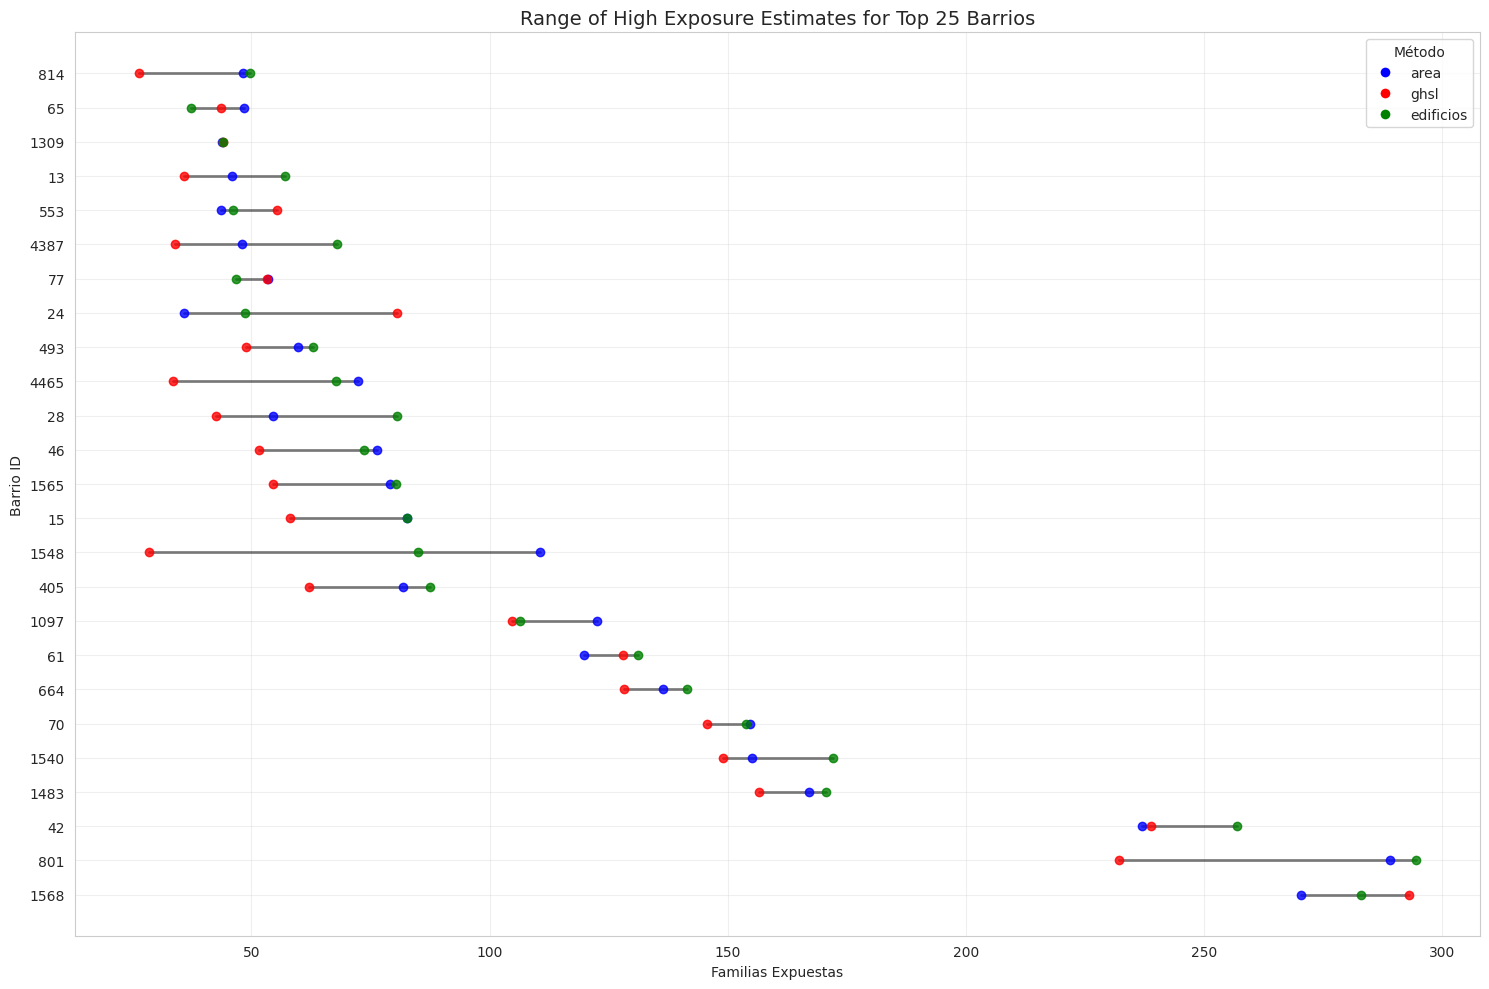

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for high exposure (alta peligrosidad)
alta_data = final_tidy[final_tidy["peligrosidad"] == "alta"].copy()

# Calculate total exposure per barrio across all methods
total_exposure = (
    alta_data.groupby("id_renabap")["fam_expuestas"]
    .sum()
    .sort_values(ascending=False)
)
top_25_barrios = total_exposure.head(25).index

# Filter data for top 25 barrios
top_25_data = alta_data[
    alta_data["id_renabap"].isin(top_25_barrios)
].copy()

# Create range plot showing min, max, and individual points
plt.figure(figsize=(15, 10))

# Define colors for methods
method_colors = {"area": "blue", "ghsl": "red", "edificios": "green"}

for i, barrio in enumerate(top_25_barrios):
    barrio_data = top_25_data[top_25_data["id_renabap"] == barrio]
    if len(barrio_data) > 0:
        values = barrio_data["fam_expuestas"].values
        min_val = values.min()
        max_val = values.max()

        # Plot range line
        plt.plot([min_val, max_val], [i, i], "k-", alpha=0.5, linewidth=2)

        # Plot individual points colored by method
        for _, row in barrio_data.iterrows():
            color = method_colors[row["metodo"]]
            plt.plot(row["fam_expuestas"], i, "o", color=color, markersize=6, alpha=0.8)

plt.yticks(range(len(top_25_barrios)), top_25_barrios)
plt.xlabel("Familias Expuestas")
plt.ylabel("Barrio ID")
plt.title("Range of High Exposure Estimates for Top 25 Barrios", fontsize=14)
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=8,
        label=method,
    )
    for method, color in method_colors.items()
]
plt.legend(handles=legend_elements, title="Método")

plt.tight_layout()
plt.show()

=== DISTRIBUTION OF EXPOSURE RANGES BY RISK LEVEL ===

ALTA PELIGROSIDAD:
  Number of barrios: 323
  Range statistics:
    Mean range: 4.26
    Median range: 0.00
    Min range: 0.00
    Max range: 82.10
    Std range: 10.41
  Top 10 barrios with highest exposure ranges:
    ID_1548: 82.10 (min: 28.46, max: 110.56)
    ID_801: 62.42 (min: 232.05, max: 294.47)
    ID_946: 45.96 (min: 0.00, max: 45.96)
    ID_74: 45.39 (min: 0.00, max: 45.39)
    ID_1083: 45.26 (min: 0.00, max: 45.26)
    ID_24: 44.73 (min: 35.84, max: 80.57)
    ID_4465: 38.88 (min: 33.51, max: 72.39)
    ID_28: 37.96 (min: 42.48, max: 80.45)
    ID_4: 36.26 (min: 0.00, max: 36.26)
    ID_4387: 33.97 (min: 33.90, max: 67.87)

BAJA PELIGROSIDAD:
  Number of barrios: 323
  Range statistics:
    Mean range: 11.57
    Median range: 0.24
    Min range: 0.00
    Max range: 164.44
    Std range: 22.08
  Top 10 barrios with highest exposure ranges:
    ID_74: 164.44 (min: 204.53, max: 368.97)
    ID_812: 146.54 (min: 416.28, ma

Text(0, 0.5, 'Exposure Range')

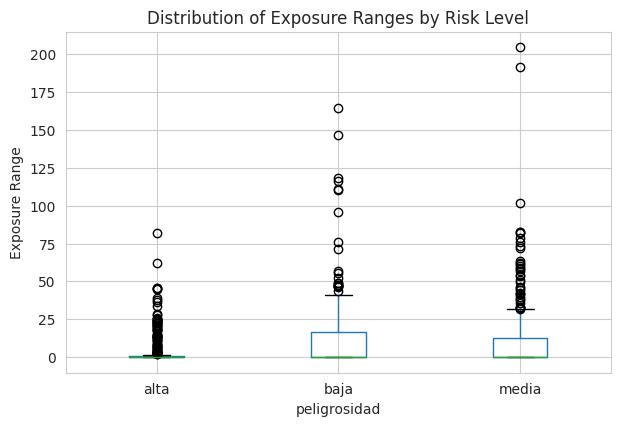

In [46]:
# Calculate range of exposure estimates for each barrio and risk level
exposure_ranges = []

for barrio_id in final_tidy["id_renabap"].unique():
    for riesgo in ["alta", "baja", "media"]:
        # Get all method estimates for this barrio and risk level
        barrio_riesgo_data = final_tidy[
            (final_tidy["id_renabap"] == barrio_id) & 
            (final_tidy["peligrosidad"] == riesgo)
        ]
        
        if len(barrio_riesgo_data) > 0:
            # Calculate range (max - min)
            exposure_values = barrio_riesgo_data["fam_expuestas"].values
            exposure_range = exposure_values.max() - exposure_values.min()
            
            # Get barrio name for reference
            barrio_name = barrio_riesgo_data["nombre_barrio"].iloc[0] if "nombre_barrio" in barrio_riesgo_data.columns else f"ID_{barrio_id}"
            
            exposure_ranges.append({
                "id_renabap": barrio_id,
                "nombre_barrio": barrio_name,
                "peligrosidad": riesgo,
                "exposure_range": exposure_range,
                "min_exposure": exposure_values.min(),
                "max_exposure": exposure_values.max(),
                "mean_exposure": exposure_values.mean(),
                "std_exposure": exposure_values.std()
            })

exposure_ranges_df = pd.DataFrame(exposure_ranges)

# Report distributions of exposure ranges by risk level
print("=== DISTRIBUTION OF EXPOSURE RANGES BY RISK LEVEL ===")
print("=" * 60)

for riesgo in ["alta", "baja", "media"]:
    riesgo_data = exposure_ranges_df[exposure_ranges_df["peligrosidad"] == riesgo]
    
    print(f"\n{riesgo.upper()} PELIGROSIDAD:")
    print(f"  Number of barrios: {len(riesgo_data)}")
    print(f"  Range statistics:")
    print(f"    Mean range: {riesgo_data['exposure_range'].mean():.2f}")
    print(f"    Median range: {riesgo_data['exposure_range'].median():.2f}")
    print(f"    Min range: {riesgo_data['exposure_range'].min():.2f}")
    print(f"    Max range: {riesgo_data['exposure_range'].max():.2f}")
    print(f"    Std range: {riesgo_data['exposure_range'].std():.2f}")
    
    # Show barrios with highest ranges
    top_ranges = riesgo_data.nlargest(10, "exposure_range")
    print(f"  Top 10 barrios with highest exposure ranges:")
    for _, row in top_ranges.iterrows():
        print(f"    {row['nombre_barrio']}: {row['exposure_range']:.2f} (min: {row['min_exposure']:.2f}, max: {row['max_exposure']:.2f})")

# Overall summary
print(f"\n" + "=" * 60)
print("OVERALL SUMMARY")
print("=" * 60)

print(f"Total barrios analyzed: {exposure_ranges_df['id_renabap'].nunique()}")
print(f"Total observations: {len(exposure_ranges_df)}")

# Calculate overall statistics
overall_stats = exposure_ranges_df.groupby("peligrosidad")["exposure_range"].agg([
    "count", "mean", "median", "std", "min", "max"
]).round(2)

print(f"\nOverall exposure range statistics by risk level:")
print(overall_stats)

# Show barrios with highest overall ranges across all risk levels
print(f"\nTop 15 barrios with highest exposure ranges across all risk levels:")
top_overall = exposure_ranges_df.nlargest(15, "exposure_range")
for _, row in top_overall.iterrows():
    print(f"  {row['nombre_barrio']} ({row['peligrosidad']}): {row['exposure_range']:.2f}")

# Create summary plots
plt.figure(figsize=(15, 10))

# Plot 1: Box plot of exposure ranges by risk level
plt.subplot(2, 2, 1)
exposure_ranges_df.boxplot(column="exposure_range", by="peligrosidad", ax=plt.gca())
plt.title("Distribution of Exposure Ranges by Risk Level")
plt.suptitle("")  # Remove default suptitle
plt.ylabel("Exposure Range")

# Plot 2: Histogram of exp

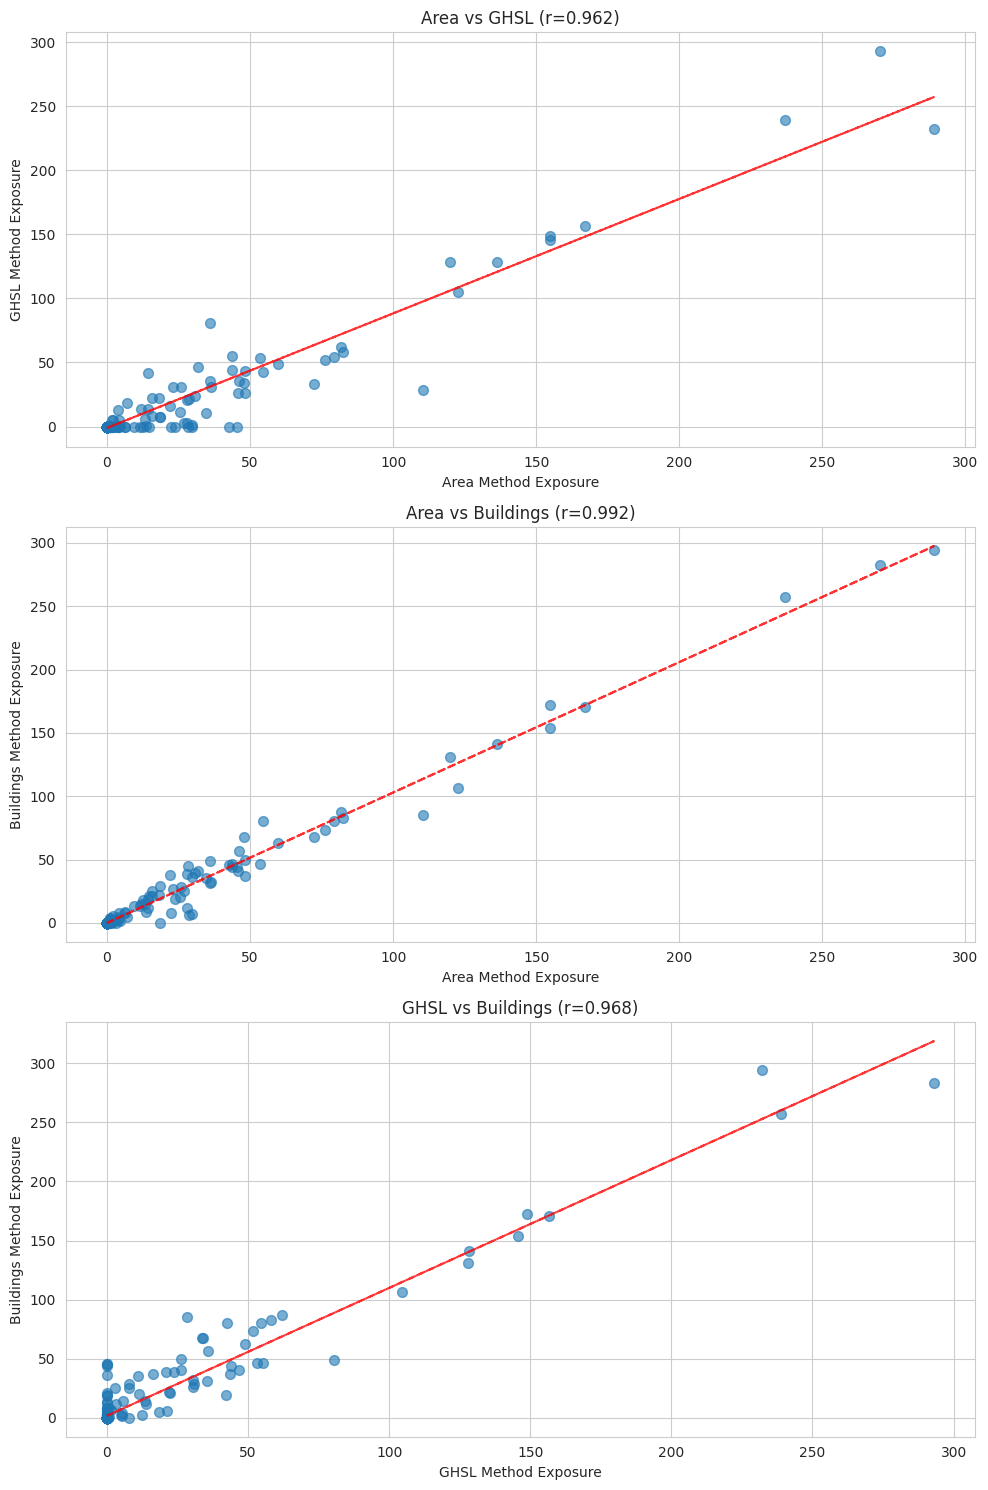

In [48]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Filter out any NaN values for the analysis
valid_data = final_tidy.dropna(subset=["fam_expuestas"])

# Create a figure with 3 subplots stacked in one column
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.set_style("whitegrid")

# Method 1: Area vs GHSL
area_ghsl_data = valid_data[
    (valid_data["metodo"].isin(["area", "ghsl"])) & 
    (valid_data["peligrosidad"] == "alta")
].pivot(index=["id_renabap", "peligrosidad"], columns="metodo", values="fam_expuestas").reset_index()

area_ghsl_data = area_ghsl_data.dropna()
if len(area_ghsl_data) > 0:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        area_ghsl_data["area"], area_ghsl_data["ghsl"]
    )
    
    axes[0].scatter(area_ghsl_data["area"], area_ghsl_data["ghsl"], alpha=0.6, s=50)
    axes[0].plot(area_ghsl_data["area"], slope * area_ghsl_data["area"] + intercept, 
                 color='red', linestyle='--', alpha=0.8)
    axes[0].set_xlabel("Area Method Exposure")
    axes[0].set_ylabel("GHSL Method Exposure")
    axes[0].set_title(f"Area vs GHSL (r={r_value:.3f})")

# Method 2: Area vs Buildings
area_buildings_data = valid_data[
    (valid_data["metodo"].isin(["area", "edificios"])) & 
    (valid_data["peligrosidad"] == "alta")
].pivot(index=["id_renabap", "peligrosidad"], columns="metodo", values="fam_expuestas").reset_index()

area_buildings_data = area_buildings_data.dropna()
if len(area_buildings_data) > 0:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        area_buildings_data["area"], area_buildings_data["edificios"]
    )
    
    axes[1].scatter(area_buildings_data["area"], area_buildings_data["edificios"], alpha=0.6, s=50)
    axes[1].plot(area_buildings_data["area"], slope * area_buildings_data["area"] + intercept, 
                  color='red', linestyle='--', alpha=0.8)
    axes[1].set_xlabel("Area Method Exposure")
    axes[1].set_ylabel("Buildings Method Exposure")
    axes[1].set_title(f"Area vs Buildings (r={r_value:.3f})")

# Method 3: GHSL vs Buildings
ghsl_buildings_data = valid_data[
    (valid_data["metodo"].isin(["ghsl", "edificios"])) & 
    (valid_data["peligrosidad"] == "alta")
].pivot(index=["id_renabap", "peligrosidad"], columns="metodo", values="fam_expuestas").reset_index()

ghsl_buildings_data = ghsl_buildings_data.dropna()
if len(ghsl_buildings_data) > 0:
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        ghsl_buildings_data["ghsl"], ghsl_buildings_data["edificios"]
    )
    
    axes[2].scatter(ghsl_buildings_data["ghsl"], ghsl_buildings_data["edificios"], alpha=0.6, s=50)
    axes[2].plot(ghsl_buildings_data["ghsl"], slope * ghsl_buildings_data["ghsl"] + intercept, 
                  color='red', linestyle='--', alpha=0.8)
    axes[2].set_xlabel("GHSL Method Exposure")
    axes[2].set_ylabel("Buildings Method Exposure")
    axes[2].set_title(f"GHSL vs Buildings (r={r_value:.3f})")

plt.tight_layout()
plt.show()

## Summary por cuenca

In [50]:
from io import BytesIO
from owslib.wfs import WebFeatureService


def wfs_to_gdf(wfs_url: str, layer_name: str, srs: str = "EPSG:4326") -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.
    
    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.
    
    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


In [52]:
cuencas = wfs_to_gdf(
     wfs_url="https://www.minfra.gba.gob.ar/sig_hidraulica/geoserver/dipsoh/wfs",
     layer_name="dipsoh:cuencas",
     srs="EPSG:900913"
)

cuencas.crs = "EPSG:900913"

cuencas = cuencas.to_crs(USE_CRS)

<Axes: >

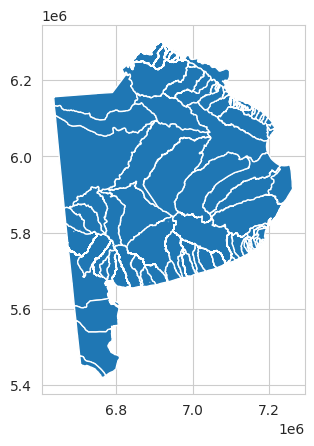

In [53]:
cuencas.plot()